# Measuring Cell Deformation

## Installs, imports, and uploads

In [1]:
# #@title Package Installations

# !pip install numpy opencv-python-headless pandas matplotlib stardist ipywidgets plotly --quiet



In [2]:
%matplotlib widget

In [3]:
# #@title File Upload

# from google.colab import files
# uploaded = files.upload()

# Just in case we're using this notebook from Colab

In [4]:
#@title Imports

import copy

import cv2
import numpy as np
from stardist.models import StarDist2D
from skimage import io, color
import pandas as pd

import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from ipywidgets import Button, HBox, interact, IntSlider, Output
from IPython.display import display, clear_output
import ipywidgets as widgets

from skimage.morphology import opening, disk, closing
from skimage.filters import gaussian
from skimage.color import label2rgb

import pandas as pd
from skimage.measure import regionprops, regionprops_table

from sklearn.decomposition import PCA


2025-05-27 10:37:54.804240: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-27 10:37:54.805108: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 10:37:54.811871: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-27 10:37:54.827563: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748353074.853077    8567 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748353074.86

## Loading Video and Frames

In [9]:
#@title Load Model and Data

# Load the pre-trained StarDist model
model = StarDist2D.from_pretrained('2D_versatile_fluo')

# Initialize a list to store segmentation results
segmentation_results = []

# Load the video
number_movie = 5 # CAMBIAR ABAJO TAMBIEN
video_path = f'videos_faisal/advs7674-sup-0006-movies5.mp4'
cap = cv2.VideoCapture(video_path)
frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

# Preload frames (we could load a subset if the video was very large)
frames = []

# Choose the number of frames to load
number_frames = 10
#for i in range(number_frames):
while True:
    ret, frame = cap.read()
    if not ret:
        break
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    frames.append(frame_rgb[:, :, 1])  # Store only the green channel

cap.release()
print(len(frames))
frames[0].shape

Found model '2D_versatile_fluo' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.479071, nms_thresh=0.3.
232


(1024, 1024)

In [10]:
#@title Rendering the Original Video

current_frame_idx = 0  # Track the current frame index

plot_output = widgets.Output()  # Dedicated output widget for the plot

def plot_frame(frame_idx):
    with plot_output:
        clear_output(wait=True)  # Clear the previous plot
        plt.figure(figsize=(8, 8))
        plt.imshow(frames[frame_idx], cmap='Greens')
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')
        plt.show()

def on_previous_clicked(b):
    global current_frame_idx
    if current_frame_idx > 0:
        current_frame_idx -= 1
        slider.value = current_frame_idx  # This triggers plot update

def on_next_clicked(b):
    global current_frame_idx
    if current_frame_idx < len(frames) - 1:
        current_frame_idx += 1
        slider.value = current_frame_idx  # This triggers plot update

previous_button = Button(description="Previous")
next_button = Button(description="Next")

previous_button.on_click(on_previous_clicked)
next_button.on_click(on_next_clicked)

slider = IntSlider(min=0, max=len(frames)-1, step=1, value=0)

def on_slider_change(change):
    global current_frame_idx
    current_frame_idx = change['new']
    plot_frame(current_frame_idx)  # Update plot directly for smoother slider action

slider.observe(on_slider_change, names='value')

controls = HBox([previous_button, next_button, slider])  # Group the controls

# Display the controls and the initial plot separately
display(controls)
display(plot_output)  # This will hold the plot
plot_frame(current_frame_idx)  # Initial plot


Output()

## Preprocessing (denoising)

In [7]:

# Apply morphological opening to each frame to remove noise
# Disk-shaped structuring element with a radius of 3 pixels
selem = disk(3)

# We will store the processed frames in a separate list
processed_frames = copy.deepcopy(frames)

# Apply Gaussian blur to each opened frame (sigma controls the amount of blurring)
processed_frames = [gaussian(frame, sigma=2) for frame in processed_frames]

# Apply morphological opening to each frame to remove noise
processed_frames = [opening(frame, selem) for frame in processed_frames]

# processed_frames = [opening(frame, selem) for frame in processed_frames]
# processed_frames = [closing(frame, selem) for frame in processed_frames]
# processed_frames = [opening(frame, selem) for frame in processed_frames]
# processed_frames = [closing(frame, selem) for frame in processed_frames]


In [8]:
#@title Rendering the Processed Video

current_frame_idx = 0  # Track the current frame index

plot_output = widgets.Output()  # Dedicated output widget for the plot

def plot_frame(frame_idx):
    with plot_output:
        clear_output(wait=True)  # Clear the previous plot
        plt.figure(figsize=(8, 8))
        plt.imshow(processed_frames[frame_idx], cmap='Greens')
        plt.title(f"Frame {frame_idx}")
        plt.axis('off')
        plt.show()

def on_previous_clicked(b):
    global current_frame_idx
    if current_frame_idx > 0:
        current_frame_idx -= 1
        slider.value = current_frame_idx  # This triggers plot update

def on_next_clicked(b):
    global current_frame_idx
    if current_frame_idx < len(processed_frames) - 1:
        current_frame_idx += 1
        slider.value = current_frame_idx  # This triggers plot update

previous_button = Button(description="Previous")
next_button = Button(description="Next")

previous_button.on_click(on_previous_clicked)
next_button.on_click(on_next_clicked)

slider = IntSlider(min=0, max=len(processed_frames)-1, step=1, value=0)

def on_slider_change(change):
    global current_frame_idx
    current_frame_idx = change['new']
    plot_frame(current_frame_idx)  # Update plot directly for smoother slider action

slider.observe(on_slider_change, names='value')

controls = HBox([previous_button, next_button, slider])  # Group the controls

# Display the controls and the initial plot separately
display(controls)
display(plot_output)  # This will hold the plot
plot_frame(current_frame_idx)  # Initial plot


Output()

## Instance Segmentation

In [9]:

# Perform segmentation on each opened frame
#segmentation_labels = [model.predict_instances(frame)[0] for frame in processed_frames]

segmentation_labels = []

for idx, frame in enumerate(processed_frames):
    labels = model.predict_instances(frame)[0]
    segmentation_labels.append(labels)
    
    if idx % 5 == 0:
        print(f"{idx+1} / {len(processed_frames)} frames processed")

functional.py (238): The structure of `inputs` doesn't match the expected structure.
Expected: ['input']
Received: inputs=Tensor(shape=(1, 1088, 1088, 1))


1 / 10 frames processed
6 / 10 frames processed


In [10]:
#@title Rendering the Segmented Video

segmentation_output = Output()  # Dedicated output widget for segmentation plots

def plot_segmentation(frame_idx):
    with segmentation_output:
        clear_output(wait=True)
        label_overlay = label2rgb(segmentation_labels[frame_idx], image=processed_frames[frame_idx], bg_label=0, alpha=0.4)
        
        plt.figure(figsize=(8, 8))
        plt.imshow(label_overlay)
        plt.title(f"Segmented Frame {frame_idx} (with Gaussian Blur)")
        plt.axis('off')
        plt.show()

def on_previous_clicked(b):
    global current_frame_idx
    if current_frame_idx > 0:
        current_frame_idx -= 1
        slider.value = current_frame_idx  # This triggers plot update

def on_next_clicked(b):
    global current_frame_idx
    if current_frame_idx < len(processed_frames) - 1:
        current_frame_idx += 1
        slider.value = current_frame_idx  # This triggers plot update

previous_button = Button(description="Previous")
next_button = Button(description="Next")

previous_button.on_click(on_previous_clicked)
next_button.on_click(on_next_clicked)

slider = IntSlider(min=0, max=len(processed_frames)-1, step=1, value=0)

def on_slider_change(change):
    global current_frame_idx
    current_frame_idx = change['new']
    plot_segmentation(current_frame_idx)  # Directly update the plot for segmentation results

slider.observe(on_slider_change, names='value')

controls = HBox([previous_button, next_button, slider])

# Display the controls and the initial segmentation plot separately
display(controls)
display(segmentation_output)  # This will hold the segmentation plot
plot_segmentation(current_frame_idx)  # Initial plot


Output()

In [29]:
# Let's plot the segmentation with labels
segmentation_output = Output()

def plot_segmentation(frame_idx):
    with segmentation_output:
        clear_output(wait=True)
        label_overlay = label2rgb(segmentation_labels[frame_idx], image=processed_frames[frame_idx], bg_label=0, alpha=0.4)
        
        fig, ax = plt.subplots(figsize=(6, 6))
        ax.imshow(label_overlay)
        
        # Iterate over all region properties
        for region in regionprops(segmentation_labels[frame_idx]):
            # Get the coordinates of the centroid of the current region
            y0, x0 = region.centroid
            # Use the label as the annotation text
            ax.text(x0, y0, str(region.label), color='cyan', fontsize=12, ha='center', va='center')
        
        ax.set_title(f"Segmented Frame {frame_idx} (with Gaussian Blur)")
        ax.axis('off')
        plt.show()

def on_previous_clicked(b):
    global current_frame_idx
    if current_frame_idx > 0:
        current_frame_idx -= 1
        slider.value = current_frame_idx  # This triggers plot update

def on_next_clicked(b):
    global current_frame_idx
    if current_frame_idx < len(processed_frames) - 1:
        current_frame_idx += 1
        slider.value = current_frame_idx  # This triggers plot update

previous_button = Button(description="Previous")
next_button = Button(description="Next")

previous_button.on_click(on_previous_clicked)
next_button.on_click(on_next_clicked)

slider = IntSlider(min=0, max=len(processed_frames)-1, step=1, value=0)

def on_slider_change(change):
    global current_frame_idx
    current_frame_idx = change['new']
    plot_segmentation(current_frame_idx)  # Directly update the plot for segmentation results

slider.observe(on_slider_change, names='value')

controls = HBox([previous_button, next_button, slider])

# Display the controls and the initial segmentation plot separately
display(controls)
display(segmentation_output)
plot_segmentation(current_frame_idx)  # Initial plot


Output()

## Extracting Properties

In [12]:
properties = [
    "label", "area", "centroid", "equivalent_diameter", "bbox_area", "convex_area", "filled_area", "major_axis_length",
    "minor_axis_length", "bbox", "weighted_centroid", "coords",
    "eccentricity", "euler_number", "extent",
    "feret_diameter_max", "max_intensity", "mean_intensity", "min_intensity",
    "orientation", "perimeter", "solidity"
]

# Keep in mind that `segmentation_labels` is a list of label matrices for
# each frame, and `processed_frames` is a list of processed frames
# corresponding to `segmentation_labels`

# Initialize an empty DataFrame to store results
properties_df = pd.DataFrame()

for frame_idx, labels in enumerate(segmentation_labels):
    # Extract properties for current frame using regionprops_table
    frame_props = regionprops_table(labels, intensity_image=processed_frames[frame_idx], properties=properties)
    
    # Convert the properties dictionary to a DataFrame
    frame_props_df = pd.DataFrame(frame_props)
    
    # Add a column for the current frame index
    frame_props_df['frame'] = frame_idx
    
    # Append the current frame's properties to the main DataFrame
    properties_df = pd.concat([properties_df, frame_props_df], ignore_index=True)

# Optional: Convert 'centroid-0' and 'centroid-1' to more descriptive column names (if required)
# properties_df.rename(columns={'centroid-0': 'centroid_y', 'centroid-1': 'centroid_x'}, inplace=True)

# Ensure "frame" is the first column
columns = ['frame'] + [col for col in properties_df.columns if col != 'frame']
properties_df = properties_df.reindex(columns=columns)

In [13]:
properties_df

,frame,label,area,centroid-0,centroid-1,equivalent_diameter,bbox_area,convex_area,filled_area,major_axis_length,...,eccentricity,euler_number,extent,feret_diameter_max,max_intensity,mean_intensity,min_intensity,orientation,perimeter,solidity
0,0,1,113.0,618.230088,369.628319,11.994835,144.0,117.0,113.0,12.311408,...,0.315464,1,0.784722,13.000000,0.643353,0.474521,0.170268,1.121705,36.970563,0.965812
1,0,2,146.0,106.267123,1017.787671,13.634257,182.0,149.0,146.0,14.547252,...,0.475772,1,0.802198,15.231546,0.621518,0.432897,0.174481,-1.075792,41.798990,0.979866
2,0,3,133.0,200.849624,82.240602,13.013103,182.0,139.0,133.0,14.293422,...,0.557181,1,0.730769,14.866069,0.383908,0.273157,0.112041,1.029519,40.627417,0.956835
3,0,4,119.0,600.126050,398.453782,12.309163,168.0,126.0,119.0,13.079150,...,0.460647,1,0.708333,14.142136,0.486476,0.381755,0.175408,1.214798,39.213203,0.944444
4,0,5,104.0,214.394231,426.115385,11.507255,144.0,110.0,104.0,11.823269,...,0.317878,1,0.722222,12.649111,0.459316,0.335434,0.148539,1.556971,35.798990,0.945455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13087,9,1314,76.0,1055.223684,1049.302632,9.836982,100.0,79.0,76.0,10.111490,...,0.327422,1,0.760000,10.770330,0.062753,0.054002,0.036046,0.991328,29.556349,0.962025
13088,9,1315,60.0,83.400000,32.366667,8.740387,80.0,64.0,60.0,9.837093,...,0.610906,1,0.750000,10.770330,0.200101,0.124273,0.053753,0.988587,27.556349,0.937500
13089,9,1316,78.0,715.525641,272.615385,9.965575,154.0,101.0,78.0,13.954300,...,0.803351,1,0.506494,14.560220,0.258316,0.199491,0.076134,-0.893156,39.834524,0.772277
13090,9,1317,106.0,1042.320755,473.726415,11.617375,182.0,130.0,106.0,13.133408,...,0.506610,1,0.582418,14.317821,0.361744,0.270110,0.099387,0.405449,40.213203,0.815385


## Object Tracking
Since segmentation is not very good (some objects are segmented as many), my approach will be to manually provide a dictionary with frames as keys (integers), and lists of labels (objects, so lists of integers) as values. Then, we'll filter the original dataframe to keep only the selected objects on each frame. With this new dataframe, we will be able to start the analysis.

In [14]:
# When labels overlap, use this cell to query if the label you're seeing
# is the correct one. Remember that you can see the coordinates of your mouse
# by right clicking in jupyter lab, and then selecting “create new view for
# cell ouput”. Use that coordinates to compare with centroid coordinates.

properties_df.loc[(properties_df['frame'] == 4) & (properties_df['label'].isin([230, 83]))][['frame', 'label', 'centroid-0', 'centroid-1']]

# Note: in the “view for cell output”, there's also a “zoom to rectangle” tool

,frame,label,centroid-0,centroid-1
5288,4,83,984.208955,928.514925
5435,4,230,523.769912,855.460177


In [15]:
# Example object_to_track dictionary
object_to_track = {
    0: [39],
    1: [52],
    2: [65],
    3: [11],
    4: [3],
    5: [7],
    6: [5],
    7: [42],
    8: [91],
    9: [105],
}

# Initialize an empty DataFrame to store filtered results
filtered_df = pd.DataFrame()

for frame, labels in object_to_track.items():
    # Filter for the current frame and specified labels
    frame_filtered = properties_df[(properties_df['frame'] == frame) & (properties_df['label'].isin(labels))]
    
    # Append the filtered DataFrame to the cumulative DataFrame
    filtered_df = pd.concat([filtered_df, frame_filtered], ignore_index=True)

# Now filtered_df contains only the rows for specified objects in each frame
filtered_df

,frame,label,area,centroid-0,centroid-1,equivalent_diameter,bbox_area,convex_area,filled_area,major_axis_length,...,eccentricity,euler_number,extent,feret_diameter_max,max_intensity,mean_intensity,min_intensity,orientation,perimeter,solidity
0,0,39,113.0,68.362832,1050.247788,11.994835,156.0,119.0,113.0,12.338591,...,0.324496,1,0.724359,13.341664,0.516333,0.397370,0.151671,-0.932998,37.213203,0.949580
1,1,52,127.0,791.338583,943.007874,12.716187,169.0,134.0,127.0,13.728147,...,0.510860,1,0.751479,14.317821,0.608350,0.444803,0.198495,0.942357,39.798990,0.947761
2,2,65,131.0,409.916031,482.961832,12.914890,169.0,136.0,131.0,13.732355,...,0.467241,1,0.775148,14.317821,0.353537,0.259388,0.116828,-0.842980,39.798990,0.963235
3,3,11,108.0,866.259259,507.731481,11.726460,144.0,114.0,108.0,12.183812,...,0.379169,1,0.750000,13.000000,0.349212,0.259912,0.117174,1.201262,36.384776,0.947368
4,4,3,148.0,230.337838,253.993243,13.727325,195.0,153.0,148.0,15.072697,...,0.557369,1,0.758974,15.811388,0.638396,0.436002,0.198064,0.376753,42.627417,0.967320
5,5,7,144.0,893.958333,159.611111,13.540550,182.0,149.0,144.0,14.407562,...,0.470992,1,0.791209,15.231546,0.363671,0.254760,0.100094,1.046164,41.798990,0.966443
6,6,5,100.0,940.380000,690.060000,11.283792,132.0,106.0,100.0,12.187116,...,0.514129,1,0.757576,12.649111,0.272816,0.215932,0.103396,0.105604,34.970563,0.943396
7,7,42,109.0,84.743119,638.211009,11.780624,144.0,115.0,109.0,12.108928,...,0.323950,1,0.756944,13.000000,0.401554,0.297180,0.124251,0.315344,36.384776,0.947826
8,8,91,127.0,274.062992,1010.377953,12.716187,169.0,134.0,127.0,12.930588,...,0.255958,1,0.751479,13.928388,0.294557,0.222030,0.098977,0.467451,39.798990,0.947761
9,9,105,151.0,600.721854,352.165563,13.865755,210.0,161.0,151.0,14.816434,...,0.481530,1,0.719048,15.811388,0.318621,0.237179,0.114720,-1.360557,44.041631,0.937888


In [30]:
# Object_to_track automatized

from scipy.spatial import cKDTree
import pickle
import os

# Initial parameters
initial_frame = 0  # The initial frame
initial_labels = [705, 224, 77, 175, 493, 691, 228, 538, 354]   # The labels we want to follow

for initial_label in initial_labels:
    # Create dictionary for tracking
    object_to_track = {}
    
    # Current frame and row corresponding to the frame and the cell
    current_frame = initial_frame
    current_row = properties_df[(properties_df['frame'] == initial_frame) & (properties_df['label'] == initial_label)]
    # Message if the initial label does not appear in the frame
    if current_row.empty:
        raise ValueError("Initial label not found.")
    
    # Build an array of the centroid corresponding to the x and y coordinate
    current_centroid = np.array([current_row.iloc[0]['centroid-0'], current_row.iloc[0]['centroid-1']])
    
    # Save the initial frame
    object_to_track[initial_frame] = initial_label
    
    # Iterate
    max_frame = properties_df['frame'].max()
    for frame in range(initial_frame + 1, max_frame + 1):
        # Go to the next frame if it is not empty
        next_frame_df = properties_df[properties_df['frame'] == frame]
        
        if next_frame_df.empty:
            break
    
        # Extract the centroids of every cell in this frame
        centroids = np.array([row[['centroid-0', 'centroid-1']].values for _, row in next_frame_df.iterrows()])
        labels = next_frame_df['label'].values
    
        # Look for the nearest cell using cKDTree
        tree = cKDTree(centroids)
        dist, idx = tree.query(current_centroid)
    
        # Threshold for max distance considerating it a cell
        if dist < 50:  # Can be different
            # Update the dict and the centroid
            object_to_track[frame] = labels[idx]
            current_centroid = centroids[idx]
        else:
            break

    # Initialize an empty DataFrame to store filtered results
    filtered_df = pd.DataFrame()
    
    for frame, labels in object_to_track.items():
        # Filter for the current frame and specified labels
        frame_filtered = properties_df[(properties_df['frame'] == frame) & (properties_df['label']==labels)]
        
        # Append the filtered DataFrame to the cumulative DataFrame
        filtered_df = pd.concat([filtered_df, frame_filtered], ignore_index=True)

    
    # Define the path
    directory = f'data_tracking_faisal/movie_{number_movie}'
    
    # Create it if does not exist
    os.makedirs(directory, exist_ok=True)

    # save it
    with open(os.path.join(directory, f'filtered_df_{initial_label}.pkl'), 'wb') as f:
        pickle.dump(filtered_df, f)
        
    # Print the result of object_to_track
    print("object_to_track: ", object_to_track)

object_to_track:  {0: 705, 1: 32, 2: 749, 3: 246, 4: 26, 5: 1147, 6: 1143, 7: 626, 8: 362, 9: 339}
object_to_track:  {0: 224, 1: 683, 2: 113, 3: 567, 4: 1098, 5: 1217, 6: 1201, 7: 107, 8: 748, 9: 814}
object_to_track:  {0: 77, 1: 14, 2: 9, 3: 155, 4: 116, 5: 778, 6: 639, 7: 273, 8: 179, 9: 27}
object_to_track:  {0: 175, 1: 275, 2: 217, 3: 640, 4: 427, 5: 748, 6: 376, 7: 790, 8: 504, 9: 695}
object_to_track:  {0: 493, 1: 407, 2: 246, 3: 549, 4: 81, 5: 50, 6: 138, 7: 444, 8: 62, 9: 62}
object_to_track:  {0: 691, 1: 387, 2: 307, 3: 265, 4: 583, 5: 773, 6: 423, 7: 388, 8: 181, 9: 791}
object_to_track:  {0: 228, 1: 154, 2: 1056, 3: 472, 4: 230, 5: 283, 6: 525, 7: 827, 8: 1193, 9: 263}
object_to_track:  {0: 538, 1: 98, 2: 655, 3: 165, 4: 108, 5: 491, 6: 414, 7: 857, 8: 115, 9: 476}
object_to_track:  {0: 354, 1: 475, 2: 1174, 3: 481, 4: 620, 5: 43, 6: 402, 7: 1040, 8: 559, 9: 234}


In [31]:
# Let's check that the centroids of all objects in the same
# frame of filtered_df are closer than certain threshold.
# This assert is just to avoid stupid errors.

# ...

## Data Analysis
We'll start by making a new dataframe with a row for each frame and a coords column that in the union of all coordinates in the objects of that frame, effectively merging the selected objects into one. Then, we should calculate:
- the area by frame;
- PCA (we could use the variance or min/max values over these directions to get the aspect ratio of the objects).

In [32]:
# Initialize an empty list to store the aggregated data
data = []

# Group filtered_df by 'frame' and aggregate coordinates
for frame, group in filtered_df.groupby('frame'):
    # Concatenate all coords lists for the current frame into a single list
    all_coords = [coord for sublist in group['coords'] for coord in sublist]
    
    # Append the aggregated data for the current frame to the data list
    data.append({'frame': frame, 'coords': all_coords})

# Create cell_df from the aggregated data
cell_df = pd.DataFrame(data)

# Display the first few rows of cell_df to verify
cell_df.head()

,frame,coords
0,0,"[[411, 319], [411, 320], [411, 321], [411, 322..."
1,1,"[[406, 320], [406, 321], [406, 322], [406, 323..."
2,2,"[[413, 325], [413, 326], [413, 327], [413, 328..."
3,3,"[[409, 320], [409, 321], [409, 322], [410, 318..."
4,4,"[[406, 321], [406, 322], [406, 323], [406, 324..."


In [33]:
# Ensure cell_df['coords'] lists have more than one unique point for PCA
cell_df = cell_df[cell_df['coords'].map(lambda x: len(np.unique(x, axis=0)) > 1)]

# Add a new column for centroids in cell_df
cell_df['centroid'] = cell_df['coords'].apply(lambda coords: np.mean(coords, axis=0))

# Initialize lists to store the PCA results and variance information
pc1_list = []
pc2_list = []
variance_list = []
explained_variance_ratio_list = []

# Perform PCA on the coordinates for each frame
for coords in cell_df['coords']:
    pca = PCA(n_components=2)  # Initialize PCA to find the first two principal components
    pca.fit(coords)  # Fit the PCA model to the coordinates
    
    pc1, pc2 = pca.components_  # Get the principal components
    variance = pca.explained_variance_  # Variance of each PC
    explained_variance_ratio = pca.explained_variance_ratio_  # Percentage of variance explained by each PC
    
    pc1_list.append(pc1)
    pc2_list.append(pc2)
    variance_list.append(variance)
    explained_variance_ratio_list.append(explained_variance_ratio)

# Add the PCA results and variance information to the cell_df DataFrame
cell_df['pc1'] = pc1_list
cell_df['pc2'] = pc2_list
cell_df['variance'] = variance_list
cell_df['explained_variance_ratio'] = explained_variance_ratio_list

# Display the DataFrame to verify the results
cell_df.head()

,frame,coords,centroid,pc1,pc2,variance,explained_variance_ratio
0,0,"[[411, 319], [411, 320], [411, 321], [411, 322...","[416.875, 321.71875]","[0.7991352784491698, 0.601151234497583]","[-0.601151234497583, 0.7991352784491698]","[11.783588572499614, 8.939836624350779]","[0.56861201565707, 0.43138798434293]"
1,1,"[[406, 320], [406, 321], [406, 322], [406, 323...","[412.9261083743842, 323.58128078817737]","[0.4999165651035525, 0.8660735695857861]","[0.8660735695857861, -0.4999165651035525]","[18.287321183036394, 14.471592146701513]","[0.5582395544981499, 0.44176044550185006]"
2,2,"[[413, 325], [413, 326], [413, 327], [413, 328...","[420.7451923076923, 324.1875]","[-0.6527320002698186, 0.7575888963176279]","[0.7575888963176279, 0.6527320002698186]","[22.094280421585772, 12.549114227227046]","[0.6377631477965718, 0.3622368522034283]"
3,3,"[[409, 320], [409, 321], [409, 322], [410, 318...","[416.8480392156863, 317.79901960784315]","[-0.5238618781440357, 0.8518032241236255]","[0.8518032241236255, 0.5238618781440357]","[24.31896839861589, 11.03595288022609]","[0.6878524267332901, 0.31214757326670994]"
4,4,"[[406, 321], [406, 322], [406, 323], [406, 324...","[411.55855855855856, 322.7837837837838]","[0.9986524780501547, -0.051896320527426994]","[0.051896320527426994, 0.9986524780501547]","[9.506473330504683, 8.34971012566764]","[0.5323911099949297, 0.4676088900050703]"


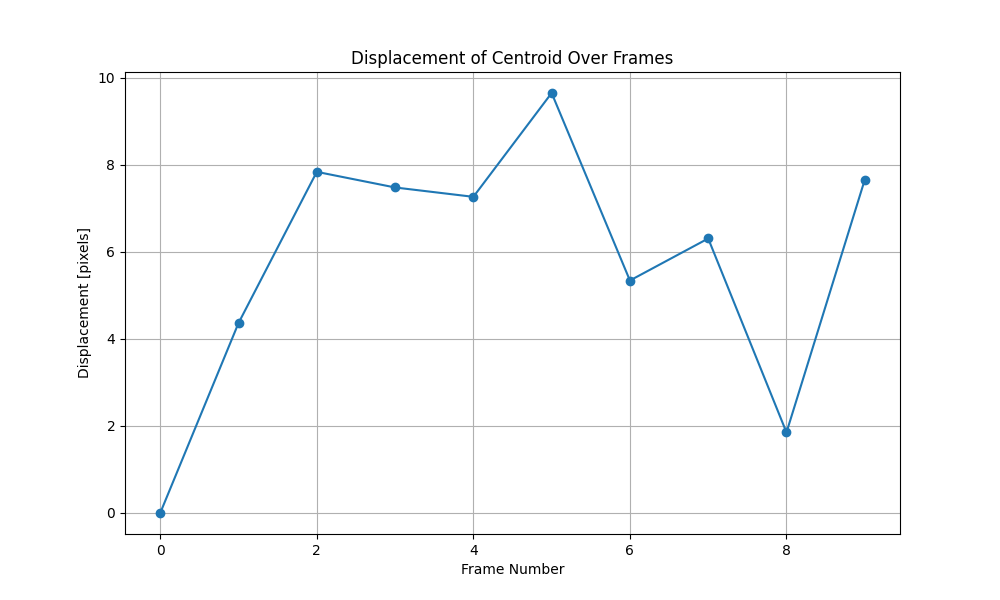

In [34]:
# Let's plot the displacement to give an idea of speed

# Calculate displacements
displacements = [0]  # The displacement for the first frame is 0 by definition
for i in range(1, len(cell_df)):
    # Calculate the Euclidean distance between consecutive centroids
    displacement = np.linalg.norm(cell_df['centroid'].iloc[i] - cell_df['centroid'].iloc[i-1])
    displacements.append(displacement)

# Add the displacements to the cell_df DataFrame
cell_df['displacement'] = displacements

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cell_df['frame'], cell_df['displacement'], marker='o', linestyle='-')
plt.title('Displacement of Centroid Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Displacement [pixels]')
plt.grid(True)
plt.show()


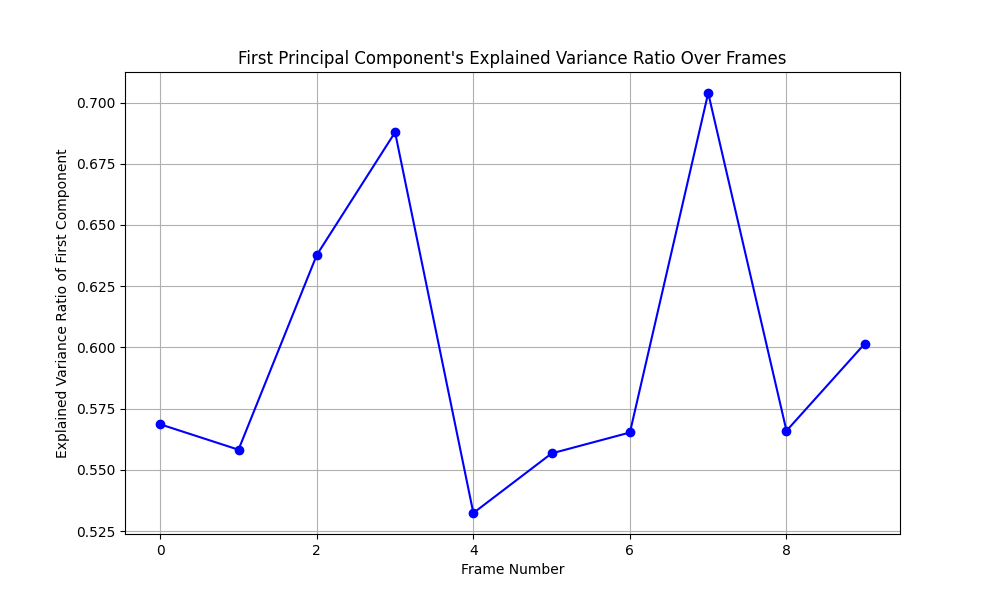

In [35]:
# Extract the first component of the explained_variance_ratio for each frame
# to give an idea of cell deformation

first_component_variance_ratio = [ratio[0] for ratio in cell_df['explained_variance_ratio']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cell_df['frame'], first_component_variance_ratio, marker='o', linestyle='-', color='blue')
plt.title('First Principal Component\'s Explained Variance Ratio Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Explained Variance Ratio of First Component')
plt.grid(True)
plt.show()


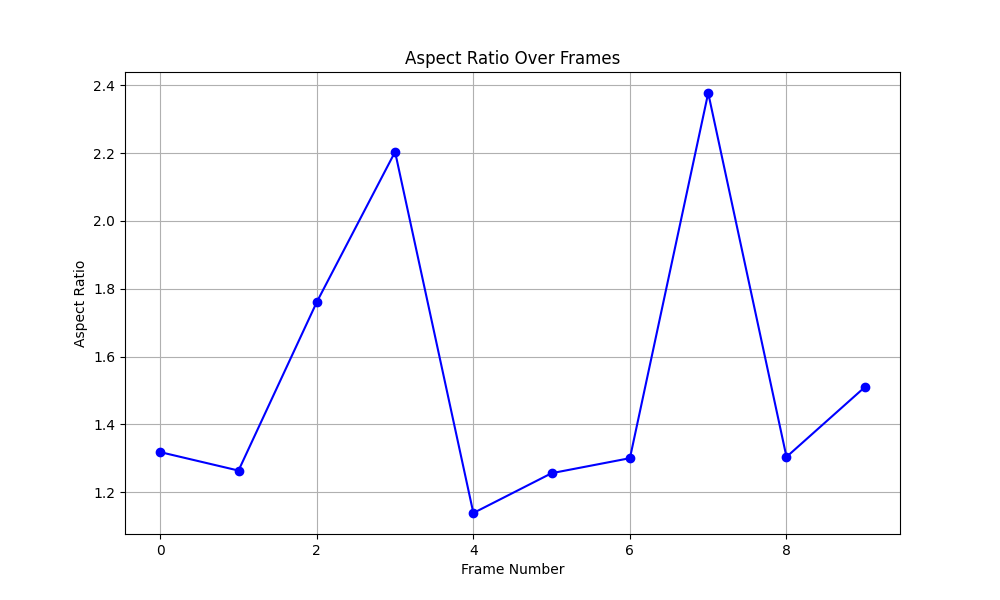

In [36]:
# Extract the aspect ratio

aspect_ratio = [ratio[0]/ratio[1] for ratio in cell_df['explained_variance_ratio']]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(cell_df['frame'], aspect_ratio, marker='o', linestyle='-', color='blue')
plt.title('Aspect Ratio Over Frames')
plt.xlabel('Frame Number')
plt.ylabel('Aspect Ratio')
plt.grid(True)
plt.show()
import pickle

with open('cell_df.pkl', 'wb') as f:
    pickle.dump(cell_df, f)
